<ipython-input-70-e2c23d4bdcd5>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_part["数量"] = data["数量"].astype("int")
<ipython-input-70-e2c23d4bdcd5>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_part["长度"] = data["长度"].astype("float")
<ipython-input-70-e2c23d4bdcd5>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

这批材料的应切割面积为:15347977.27
{'1': 11175.0, '2': 2003.0}
the cost of bin is:19767000.0


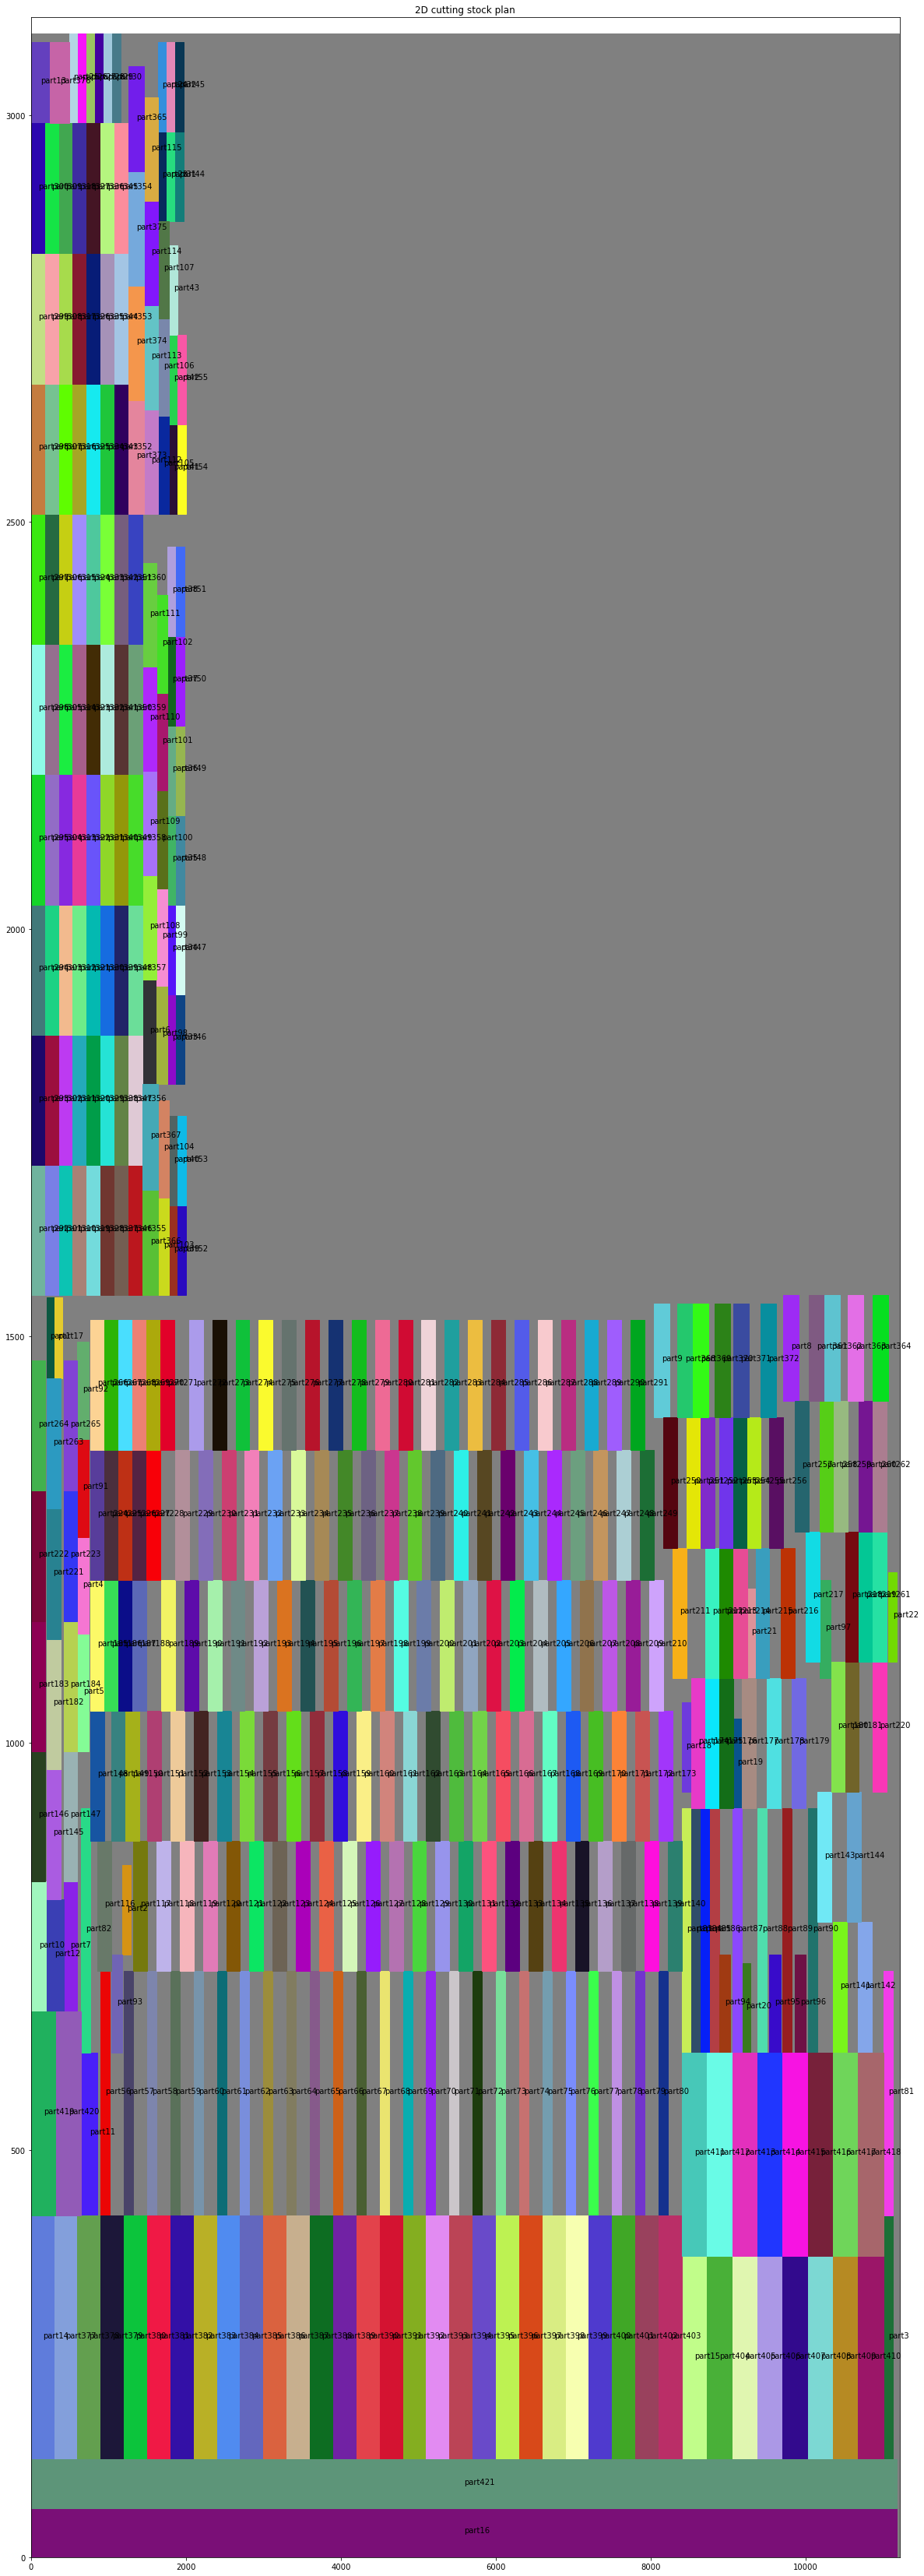

In [70]:
import CutStock
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
# 没看懂这些keys值的作用？？？？？
# test_dict = {'1': [45, 20], '2': [45, 20], '3': [45, 20],
#              '4': [55, 25], '5': [35, 23]}
# sheet_size = [96.0, 48.0]


def parse_output():
    # 使用原材料板材情况
    sheet_lists = output['results']['sheets']
    # 使用原材料板材的个数
    sheet_cnt = len(sheet_lists)
    # 原材料的左下角坐标集合
    sheet_points = []
    for i, sheet in enumerate(sheet_lists):
        # 获取当前sheet的左下角坐标
        cur_point = [sheet['x'], sheet['y']]
        sheet_points.append(cur_point)

    # 整合每一个原材料的分拆结果
    parts = output['results']['parts']
    part_infos = []

    for part in parts:
        # 获取label对应的part尺寸
        part_size = test_dict[part['part']]
        # 整合每一个part的信息，包括part下标,左下角的坐标(x, y),宽度，高度
        part_infos.append([part['part'], part['x'], part['y'], part_size[0], part_size[1]])

    return sheet_points, part_infos, sheet_cnt


def display():
    # 设置各part颜色
    colors = []
    for i in range(len(test_dict.keys())):
        colors.append(list(np.random.choice(range(256), size=3) / 255))

    fig = plt.figure(figsize = (20,60))
    ax = fig.add_subplot()
    # 绘制原材料的位置
    for i, point in enumerate(sheet_points):
        ax.add_patch(
            patches.Rectangle(
                (point[0], point[1]),  # (x, y)
                sheet_size[0],  # width
                sheet_size[1],  # height
                color='gray'
            ))

    # 绘制分拆结果
    for i, part in enumerate(part_infos):
        ax.add_patch(
            patches.Rectangle(
                (part[1], part[2]),  # (x, y)
                part[3],  # width
                part[4],  # height
                color=colors[i],
            ))
        center_x, center_y = part[1] + part[3] / 2, part[2] + part[4] / 2
        ax.text(center_x, center_y, 'part' + part[0])

    # 设置坐标轴范围(需要修改)
    plt.xlim((0, sheet_size[0] + 10))
    y_coordinate = sheet_cnt * sheet_size[1] + 5 * sheet_cnt + 10
    plt.ylim((0, y_coordinate))
    plt.title('2D cutting stock plan')
    plt.show()

def chai_tolist(path, s_name, thickness, ss):
    #路径
    data = pd.read_excel(path, sheet_name = s_name)
    
#     #截面拆分
#     data2 = pd.DataFrame((x.split('*') for x in data["型材"]),
#                     index = data.index, columns = ["厚度", "宽度2"])
#     data = pd.merge(data, data2, right_index = True, left_index = True)
#     data["厚度"] = data["厚度"].astype("str")
    data_part = data[data['厚度'].isin([thickness])]
    #格式转换str to int
    data_part["数量"] = data["数量"].astype("int")
    data_part["长度"] = data["长度"].astype("float")
    data_part["宽度"] = data["宽度"].astype("int")
    data_part["厚度"] = data["厚度"].astype("int")
    
    
    #转换list
    length_list = data_part["长度"].values.tolist()
    width_list = data_part["宽度"].values.tolist()
    num_list = data_part["数量"].values.tolist()
    
    #长度延展
    for x, y in zip(length_list, num_list):
        for i in range(y-1):
            length_list.append(x)


    #宽度延展
    for x, y in zip(width_list, num_list):
        for i in range(y-1):
            width_list.append(x)
    
    part_m2 = 0
    for x, y in zip(length_list, width_list):
        m2 = x*y
        part_m2 += m2
    print(f"这批材料的应切割面积为:{part_m2}")

    #制作长宽合并列表
    w_l_list = []
    for x, y in zip(length_list, width_list):
        merge_list = []
        if x >= sheet_size[0]:
            add_list = []
            num = x - sheet_size[0] - 50
            add_list.append(num)
            add_list.append(y)
            x = sheet_size[0] - 50
            w_l_list.append(add_list)
        merge_list.append(x)
        merge_list.append(y)
        w_l_list.append(merge_list)
        
    #制作字典索引 
    index_list = []
    index = 1
    for i in range(len(w_l_list)):
        input_index = str(index)
        index_list.append(input_index)
        index += 1
        
    #合并为part字典
    part_dict = dict(zip(index_list, w_l_list))
    
    return part_dict
## ````````````````````````````````````````````````````





def csp1d_tolist(path, s_name, mark, ss):
    #路径
    data = pd.read_excel(path, sheet_name = s_name)
    
    #截面拆分
#     data2 = pd.DataFrame((x.split('*') for x in data["型材"]),
#                     index = data.index, columns = ["厚度", "宽度"])
#     data = pd.merge(data, data2, right_index = True, left_index = True)
    data_part = data[data['型材'].isin([mark])]
    
    #格式转换str to int
    data_part["长度"] = data["长度"].astype("float")
    data_part["数量"] = data["数量"].astype("int")
    print(data_part)
    #转换list
    length_list = data_part["长度"].values.tolist()
    num_list = data_part["数量"].values.tolist()
    width_list = []
    #长度延展
    for x, y in zip(length_list, num_list):
        for i in range(y-1):
            length_list.append(x)
            width_list.append(100)
    
    part_m2 = 0
    for x, y in zip(length_list, width_list):
        part_m2 += x
    print(f"这批材料的应切割长度为:{part_m2}")

    #制作长宽合并列表
    w_l_list = []
    for x, y in zip(length_list, width_list):
        merge_list = []
        if x >= sheet_size[0]:
            add_list = []
            num = x - sheet_size[0] - 50
            add_list.append(num)
            add_list.append(y)
            x = sheet_size[0] - 50
            w_l_list.append(add_list)
        merge_list.append(x)
        merge_list.append(y)
        w_l_list.append(merge_list)
        
    #制作字典索引 
    index_list = []
    index = 1
    for i in range(len(w_l_list)):
        input_index = str(index)
        index_list.append(input_index)
        index += 1
        
    #合并为part字典
    part_dict = dict(zip(index_list, w_l_list))
    
    return part_dict
"""## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````
## ````````````````````````````````````````````````````"""

if __name__ == '__main__':
    #选择2D
    csp2d = True
    
    if csp2d:
        
    # 原材料钢板尺寸
        default_mis = 50
        sheet_size = [11200, 1500 + default_mis]
        # 从excel获取原数据，需要重写
        test_dict = chai_tolist(path = 'huayuab.xls', s_name = "Q235B-2d", thickness = 10, ss = sheet_size)
    #     chai_tolist(path = 'huayu_ab1625.xls', thickness = '8')

    #     # 客户订单尺寸
    #     test_dict = {'1': [45, 20], '2': [45, 20], '3': [20, 20],
    #                  '4': [55, 25], '5': [35, 23]}

        output = CutStock.CutStock(test_dict, sheet_size)
    #     print(output)    
    # #·····················································   
        dic1 = output["results"]
        dic2 = dic1["parts"]
        finish_part_list = []
        x_list = []
        y_list = []
        sheet_index_list = []
        for i in range(len(dic2)):
            current_mark = dic2[i]
            dic_part = current_mark['part']
            dic_x = current_mark['x']
            dic_y = current_mark['y']
            dic_index = current_mark['sheet_index']

            finish_part_list.append(dic_part)
            x_list.append(dic_x)
            y_list.append(dic_y)
            sheet_index_list.append(dic_index)

        #所有零件坐标pandas
        pdpart = pd.DataFrame(finish_part_list, columns = ['part'])
        pdx = pd.DataFrame(x_list, columns = ['x'])
        pdy = pd.DataFrame(y_list, columns = ['y'])
        pds = pd.DataFrame(sheet_index_list, columns = ['sheet_index'])
        zuobiao = pd.concat([pdpart, pdx, pdy, pds],axis=1)

        lastx_list = []
        index_list = []
        #遍历取每个零件最大的左下坐标
        last_sheet = zuobiao['sheet_index'].max() + 1
        for i in range(last_sheet):
            mark_partlist = []
            mark_xlist = []
            partx = []
            nc_data = zuobiao[zuobiao['sheet_index'].isin([i])]
            mark_partlist = nc_data["part"].values.tolist()
            mark_xlist = nc_data['x'].values.tolist()
    #         mark_xlist = list(map(float, mark_xlist))
            #全部去除该sheet对应part的x长值并放在列表中
            for i in range(len(mark_partlist)):
                part_num = mark_partlist[i]
                #遍历零件列表取x并加起来
                mmm = mark_xlist[i]
                for i in test_dict.keys():
                    if part_num == i:
                        xy = test_dict[i]
                        nnn = mmm + xy[0]
                        partx.append(nnn)
            sheet_part_max = max(partx)
            lastx_list.append(sheet_part_max)
    #                 partx.append(xy[0])
    #         pdpartx = pd.DataFrame(partx, columns = ['partx'])
    #         nc_data = pd.concat([nc_data, pdpartx],axis=1)


    #         nc_data1 = nc_data[nc_data['x'].isin([mark_x])]
    #         mark_partlist = nc_data1['part']
    #         mark_part = mark_partlist[0]


    #         for i in test_dict.keys():
    #             if mark_part == i:
    #                 xy = test_dict[i]

    #         last_x = mark_x%9000
    #         index_list.append(i+1)
    #         lasty_list.append(last_y)
    #   创建索引列
        index = 1
        for i in range(len(lastx_list)):
            input_index = str(index)
            index_list.append(input_index)
            index += 1

        sheet_dict = dict(zip(index_list, lastx_list))
        print(sheet_dict)

        sum_x = 0
        for i in lastx_list:
            sum_x += i
        print(f"the cost of bin is:{sum_x*sheet_size[1] - sum_x*default_mis}")
    # #··························································    
        sheet_points, part_infos, sheet_cnt = parse_output()

        display()
#############################################1D############################################
    else:
        # 原材料钢板尺寸
        defalut_x = 100
        sheet_size = [9000, defalut_x]
        # 从excel获取原数据，需要重写
        test_dict = csp1d_tolist(path = '1dtest.xls', s_name = "Q235B-1d", mark = "D25", ss = sheet_size)
    #     chai_tolist(path = 'huayu_ab1625.xls', thickness = '8')

    #     # 客户订单尺寸
    #     test_dict = {'1': [45, 20], '2': [45, 20], '3': [20, 20],
    #                  '4': [55, 25], '5': [35, 23]}

        output = CutStock.CutStock(test_dict, sheet_size)
    #     print(output)    

    # #·····················································   
        dic1 = output["results"]
        dic2 = dic1["parts"]
        finish_part_list = []
        x_list = []
        y_list = []
        sheet_index_list = []
        for i in range(len(dic2)):
            current_mark = dic2[i]
            dic_part = current_mark['part']
            dic_x = current_mark['x']
            dic_y = current_mark['y']
            dic_index = current_mark['sheet_index']

            finish_part_list.append(dic_part)
            x_list.append(dic_x)
            y_list.append(dic_y)
            sheet_index_list.append(dic_index)

        #所有零件坐标pandas
        pdpart = pd.DataFrame(finish_part_list, columns = ['part'])
        pdx = pd.DataFrame(x_list, columns = ['x'])
        pdy = pd.DataFrame(y_list, columns = ['y'])
        pds = pd.DataFrame(sheet_index_list, columns = ['sheet_index'])
        zuobiao = pd.concat([pdpart, pdx, pdy, pds],axis=1)

        lastx_list = []
        index_list = []
        #遍历取每个零件最大的左下坐标
        last_sheet = zuobiao['sheet_index'].max() + 1
        for i in range(last_sheet):
            mark_partlist = []
            mark_xlist = []
            partx = []
            nc_data = zuobiao[zuobiao['sheet_index'].isin([i])]
            mark_partlist = nc_data["part"].values.tolist()
            mark_xlist = nc_data['x'].values.tolist()
    #         mark_xlist = list(map(float, mark_xlist))
            #全部去除该sheet对应part的x长值并放在列表中
            for i in range(len(mark_partlist)):
                part_num = mark_partlist[i]
                #遍历零件列表取x并加起来
                mmm = mark_xlist[i]
                for i in test_dict.keys():
                    if part_num == i:
                        xy = test_dict[i]
                        nnn = mmm + xy[0]
                        partx.append(nnn)
            sheet_part_max = max(partx)
            lastx_list.append(sheet_part_max)
    #                 partx.append(xy[0])
    #         pdpartx = pd.DataFrame(partx, columns = ['partx'])
    #         nc_data = pd.concat([nc_data, pdpartx],axis=1)


    #         nc_data1 = nc_data[nc_data['x'].isin([mark_x])]
    #         mark_partlist = nc_data1['part']
    #         mark_part = mark_partlist[0]


    #         for i in test_dict.keys():
    #             if mark_part == i:
    #                 xy = test_dict[i]

    #         last_x = mark_x%9000
    #         index_list.append(i+1)
    #         lasty_list.append(last_y)
    #   创建索引列
        index = 1
        for i in range(len(lastx_list)):
            input_index = str(index)
            index_list.append(input_index)
            index += 1

        sheet_dict = dict(zip(index_list, lastx_list))
        print(sheet_dict)

        sum_x = 0
        for i in lastx_list:
            sum_x += i
        print(f"the cost of bin is:{sum_x*sheet_size[1]}")
    # #··························································    
        sheet_points, part_infos, sheet_cnt = parse_output()

        display()